In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
import joblib

In [2]:
df = pd.read_csv("Data/text_phishing.csv")
df

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email
...,...,...,...
18645,18646,date a lonely housewife always wanted to date ...,Phishing Email
18646,18647,request submitted : access request for anita ....,Safe Email
18647,18648,"re : important - prc mtg hi dorn & john , as y...",Safe Email
18648,18649,press clippings - letter on californian utilit...,Safe Email


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB
None


In [4]:
df.isnull().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

In [5]:
df["Email Type"].value_counts()

Email Type
Safe Email        11322
Phishing Email     7328
Name: count, dtype: int64

In [6]:
# Eliminar filas con texto vacío o nulo
df = df.dropna()
df.isnull().sum()

Unnamed: 0    0
Email Text    0
Email Type    0
dtype: int64

In [7]:
df = df.drop('Unnamed: 0', axis=1)

In [8]:
#Se pasa las columnas a la nomenclatura snake_case
df = df.rename(columns={'Email Text': 'email_text', 'Email Type': 'email_type'})

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18634 entries, 0 to 18649
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   email_text  18634 non-null  object
 1   email_type  18634 non-null  object
dtypes: object(2)
memory usage: 436.7+ KB


In [10]:
# Añadir una columna Label, mapear los valores de Email Type para convertirlos a numéricos
df['label'] = df['email_type'].map({'Phishing Email': 1, 'Safe Email': 0})

In [11]:
df = df.drop(columns=['email_type'])

In [12]:
df['email_length'] = df['email_text'].apply(len)

In [13]:
df.describe()

,label,email_length
count,18634.000000,1.863400e+04
mean,0.392401,2.755654e+03
std,0.488298,1.248677e+05
min,0.000000,1.000000e+00
25%,0.000000,4.040000e+02
50%,0.000000,8.815000e+02
75%,1.000000,1.880000e+03
max,1.000000,1.703669e+07


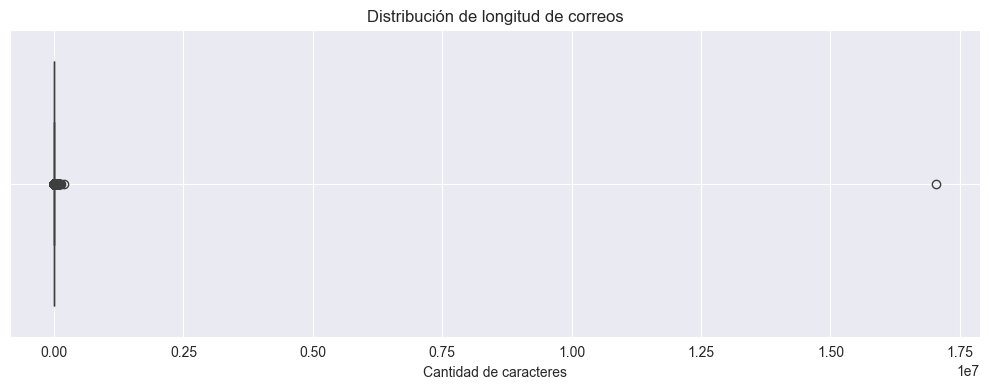

In [14]:
# Visualizar distribución de longitudes
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='email_length')
plt.title("Distribución de longitud de correos")
plt.xlabel("Cantidad de caracteres")
plt.grid(True) # Mostrar la grilla del fondo
plt.tight_layout() # Ajusta automáticamente el gráfico para que no se corte
plt.show()

In [15]:
df['email_length'].sort_values(ascending=False)

12500    17036692
11294      194978
8068       129635
15993      120761
10804      107989
           ...   
7136            5
14967           4
9605            1
13593           1
16281           1
Name: email_length, Length: 18634, dtype: int64

In [16]:
# Eliminar correos con longitud mayor al percentil 99.5 (outliers extremos)
threshold = df['email_length'].quantile(0.995)
df = df[df['email_length'] <= threshold]

In [17]:
# Escalar longitud del correo
scaler = StandardScaler()
df['email_length_scaled'] = scaler.fit_transform(df[['email_length']])

In [18]:
df

,email_text,label,email_length,email_length_scaled
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0,1030,-0.259094
1,the other side of * galicismos * * galicismo *...,0,479,-0.497980
2,re : equistar deal tickets are you still avail...,0,1245,-0.165880
3,\nHello I am your hot lil horny toy.\n I am...,1,688,-0.407368
4,software at incredibly low prices ( 86 % lower...,1,441,-0.514455
...,...,...,...,...
18645,date a lonely housewife always wanted to date ...,1,237,-0.602900
18646,request submitted : access request for anita ....,0,477,-0.498848
18647,"re : important - prc mtg hi dorn & john , as y...",0,1214,-0.179320
18648,press clippings - letter on californian utilit...,0,213,-0.613305


In [19]:
df.duplicated().sum()

np.int64(1091)

In [20]:
df[df.duplicated()]

,email_text,label,email_length,email_length_scaled
130,empty,1,5,-0.703484
244,empty,1,5,-0.703484
305,empty,1,5,-0.703484
335,empty,1,5,-0.703484
378,empty,1,5,-0.703484
...,...,...,...,...
18607,empty,0,5,-0.703484
18626,empty,0,5,-0.703484
18637,empty,1,5,-0.703484
18643,empty,0,5,-0.703484


In [21]:
df = df.drop_duplicates(keep='first')

In [22]:
# 5. Preparar datos para ML
X_text = df['email_text']  # features: cuerpo del email
X_num = df[['email_length_scaled']]
y = df['label']       # etiquetas: 1 = phishing, 0 = legítimo

In [23]:
# Dividir en entrenamiento y prueba
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_num, y, test_size=0.2, stratify=y, random_state=42
)

In [24]:
# Convertimos texto a vectores numéricos con TF-IDF
tfidf_body = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_tfidf = tfidf_body.fit_transform(X_train_text)
X_test_tfidf = tfidf_body.transform(X_test_text)

In [25]:
# Unir vectores TF-IDF + numéricos normalizados
X_train_final = hstack([X_train_tfidf, X_train_num])
X_test_final = hstack([X_test_tfidf, X_test_num])

In [26]:
# 1. Definir el modelo base
log_reg = LogisticRegression(random_state=42)

# 2. Definir los hiperparámetros a probar
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200, 300, 500]
}

# 3. Aplicar búsqueda de hiperparámetros con validación cruzada
grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# 4. Entrenar el modelo con el mejor conjunto de hiperparámetros
grid.fit(X_train_final, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'max_iter': [100, 200, 300, 500], 'penalty': ['l2'],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='f1', verbose=1)

In [27]:
# Predicciones
y_pred = grid.predict(X_test_final)

# Reporte
print("\n Mejores parámetros encontrados:", grid.best_params_)
print("\n Reporte de Clasificación:\n", classification_report(y_test, y_pred, target_names=["Safe", "Phishing"]))
print("\n Matriz de Confusión:\n", confusion_matrix(y_test, y_pred))


 Mejores parámetros encontrados: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

 Reporte de Clasificación:
               precision    recall  f1-score   support

        Safe       0.99      0.98      0.99      2184
    Phishing       0.97      0.98      0.98      1306

    accuracy                           0.98      3490
   macro avg       0.98      0.98      0.98      3490
weighted avg       0.98      0.98      0.98      3490


 Matriz de Confusión:
 [[2148   36]
 [  26 1280]]


In [28]:
print("Mejor configuración:", grid.best_params_)
print("Mejor F1 Score CV:", grid.best_score_)

Mejor configuración: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor F1 Score CV: 0.9762904879822484


In [29]:
# Entrenamos una regresión logística
model_body = LogisticRegression(
    C=10,
    max_iter=100,
    penalty='l2',
    solver='liblinear',
    random_state=42
)
model_body.fit(X_train_final, y_train)

LogisticRegression(C=10, random_state=42, solver='liblinear')

In [30]:
# 8. Evaluación del modelo
# Predicciones
y_pred_final = model_body.predict(X_test_final)

In [31]:
# Probabilidades y predicciones
y_proba = grid.best_estimator_.predict_proba(X_test_final)[:, 1]
y_pred = grid.best_estimator_.predict(X_test_final)

# Métricas
print("=== Resultados del Modelo en Cuerpo de Correos ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")

=== Resultados del Modelo en Cuerpo de Correos ===
Accuracy:  0.9822
Precision: 0.9726
Recall:    0.9801
F1 Score:  0.9764
ROC AUC:   0.9979


In [32]:
# Matriz de confusión
print("\n🧮 Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))


🧮 Matriz de confusión:
[[2148   36]
 [  26 1280]]


In [33]:
print(classification_report(y_test, y_pred, target_names=["Safe", "Phishing"]))

              precision    recall  f1-score   support

        Safe       0.99      0.98      0.99      2184
    Phishing       0.97      0.98      0.98      1306

    accuracy                           0.98      3490
   macro avg       0.98      0.98      0.98      3490
weighted avg       0.98      0.98      0.98      3490



In [34]:
joblib.dump(grid.best_estimator_, "model_body_en.pkl")
joblib.dump(tfidf_body, "tfidf_body_en.pkl")
joblib.dump(scaler, "scaler_en.pkl")

print("Exported model")
print("Exported tfidf_body")
print("Exported scaler")

Exported model
Exported tfidf_body
Exported scaler


In [35]:
model = joblib.load("model_body_en.pkl")
print("⛳️ Número de columnas que espera el modelo:", model.n_features_in_)

⛳️ Número de columnas que espera el modelo: 10001
